In [1]:
import json
import os

import pandas as pd
from matplotlib.pyplot import savefig
from scipy.stats import spearmanr
from sklearn.decomposition import PCA

from src.features.perspective import parse_summary_scores
import seaborn as sns

import numpy as np
from matplotlib import pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf



In [2]:
parents = pd.read_json('../data/interim/labeled_contributions_nobots.jsonl', lines=True, orient='records')

In [3]:
direct_labeling_fullnames = set(pd.read_csv('../data/interim/direct_labeling_strategy_4s.csv', index_col=0).fullname)
with pd.read_json('../data/interim/labeling_contributions_preprocessed_no_bot.jsonl', orient='records', lines=True, chunksize=500) as reader:
    labeling = pd.concat(chunk[chunk.fullname.isin(direct_labeling_fullnames)][[ 'author', 'created_utc',
           'subreddit','text', 'fullname', 'parent_fullname',
           'link_fullname',]] for chunk in reader)

In [4]:
labeling_pairs = pd.merge(labeling.loc[~labeling.author.isin({'[removed]', '[deleted]'}), ['author', 'fullname', 'parent_fullname']], parents[['author', 'fullname']], left_on='parent_fullname', right_on='fullname', how='inner', suffixes=['', '_parent'])

In [5]:
del labeling_pairs['fullname_parent']

In [6]:
with open('../data/interim/labeler_sub_dimensions.jsonl', encoding='utf8') as f:
    dims = dict()
    for obj in map(json.loads, f):
        dims.update(obj)
dims_df = pd.DataFrame(dims).T

with open('../data/interim/labeler_sub_conspiracy.jsonl', encoding='utf8') as f:
    consp = dict()
    for obj in map(json.loads, f):
        consp.update(obj)

consp_df=pd.DataFrame.from_dict(consp, orient='index')
consp_df.columns=['conspiracy']
labeler_df = pd.merge(consp_df, dims_df, left_index=True, right_index=True)

In [7]:
with open('../data/interim/labeled_sub_dimensions.jsonl', encoding='utf8') as f:
    dims = dict()
    for obj in map(json.loads, f):
        dims.update(obj)
dims_df = pd.DataFrame(dims).T

with open('../data/interim/labeled_sub_conspiracy.jsonl', encoding='utf8') as f:
    consp = dict()
    for obj in map(json.loads, f):
        consp.update(obj)

consp_df=pd.DataFrame.from_dict(consp, orient='index')
consp_df.columns=['conspiracy']
labeled_df = pd.merge(consp_df, dims_df, left_index=True, right_index=True)

In [8]:
user_cols = ['conspiracy', 'affluence', 'age', 'edginess', 'partisan', 'partisan neutral', 'sociality', 'time']

In [9]:
labeling_pairs = pd.merge(labeling_pairs, labeler_df[user_cols], left_on='author', right_index=True)

In [10]:
labeling_pairs = pd.merge(labeling_pairs, labeled_df[user_cols], left_on='author_parent', right_index=True, suffixes=['', '_parent'])

In [11]:
len(labeling_pairs), len(labeler_df), len(labeled_df)

(3806, 560366, 3847)

In [12]:
labeling_pairs[user_cols+[f'{c}_parent' for c in user_cols]].corr()

,conspiracy,affluence,age,edginess,partisan,partisan neutral,sociality,time,conspiracy_parent,affluence_parent,age_parent,edginess_parent,partisan_parent,partisan neutral_parent,sociality_parent,time_parent
conspiracy,1.000000,-0.062946,0.141958,0.359308,0.408378,0.454704,-0.200956,0.142185,0.296248,0.062910,0.091463,0.150573,0.138397,0.219460,-0.126306,0.033684
affluence,-0.062946,1.000000,0.469156,0.082701,-0.078557,0.274432,-0.333968,-0.267923,0.037396,0.387420,0.197696,0.107113,-0.006319,0.173811,-0.184867,-0.107164
age,0.141958,0.469156,1.000000,0.175407,-0.258119,0.367694,-0.731000,-0.486067,0.051544,0.226679,0.389171,0.089935,-0.085255,0.158124,-0.297684,-0.195532
edginess,0.359308,0.082701,0.175407,1.000000,0.400970,0.315210,-0.423124,-0.283037,0.143529,0.107043,0.099551,0.346141,0.153952,0.204383,-0.195429,-0.072675
partisan,0.408378,-0.078557,-0.258119,0.400970,1.000000,0.113271,0.096309,0.252882,0.150200,-0.012272,-0.076002,0.137242,0.307701,0.099614,0.014065,0.106015
partisan neutral,0.454704,0.274432,0.367694,0.315210,0.113271,1.000000,-0.466818,0.029662,0.179356,0.178999,0.173189,0.181328,0.071808,0.432951,-0.240565,0.017773
sociality,-0.200956,-0.333968,-0.731000,-0.423124,0.096309,-0.466818,1.000000,0.591987,-0.081626,-0.198597,-0.300080,-0.190995,0.017120,-0.235298,0.387325,0.222619
time,0.142185,-0.267923,-0.486067,-0.283037,0.252882,0.029662,0.591987,1.000000,0.035037,-0.125951,-0.194374,-0.120970,0.086593,-0.015876,0.224695,0.341531
conspiracy_parent,0.296248,0.037396,0.051544,0.143529,0.150200,0.179356,-0.081626,0.035037,1.000000,-0.130019,0.180130,0.426534,0.451663,0.460109,-0.289627,0.119281
affluence_parent,0.062910,0.387420,0.226679,0.107043,-0.012272,0.178999,-0.198597,-0.125951,-0.130019,1.000000,0.411093,-0.002603,-0.126579,0.289897,-0.291647,-0.176931


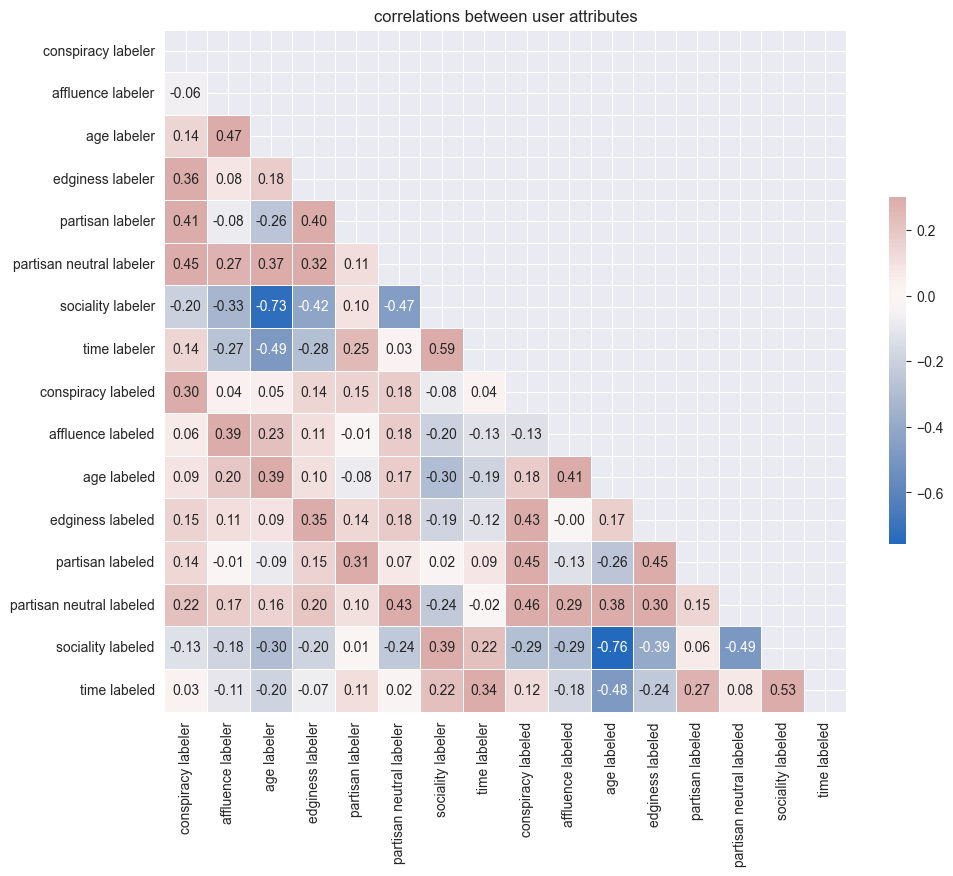

In [13]:

# Compute the correlation matrix
corr = labeling_pairs[user_cols+[f'{c}_parent' for c in user_cols]].rename(columns=lambda x: x.split('_')[0] +' labeled' if '_' in x else x+' labeler').corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)
with sns.axes_style("white"):
    # Draw the heatmap with the mask and correct aspect ratio
    ax=sns.heatmap(corr, mask=mask, #cmap=cmap,
                vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, cmap='vlag', annot=True, fmt='.2f')
    _=ax.set_title('correlations between user attributes')
    _ = savefig(f'../reports/figures/labeler_labeled_attribute_correlation.png', dpi=300, transparent=False)
    _ = savefig(f'../reports/figures/labeler_labeled_attribute_correlation.pdf', transparent=False, bbox_inches='tight', )

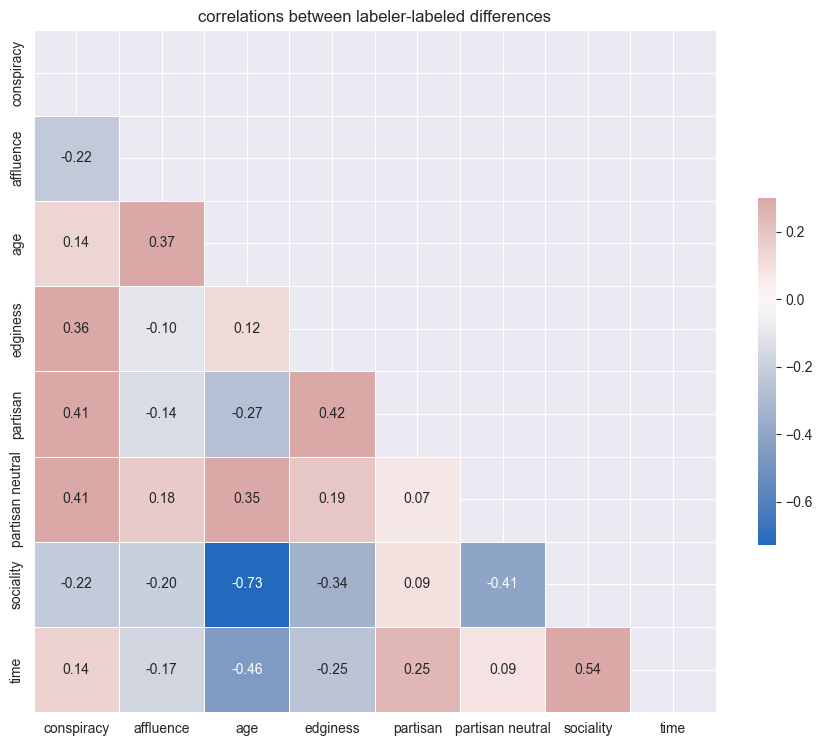

In [14]:
diff_df= pd.DataFrame(
    {col: labeling_pairs[col] - labeling_pairs[f'{col}_parent'] for col in user_cols})
# Compute the correlation matrix
corr = diff_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, mask=mask, #cmap=cmap,
                vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, cmap='vlag', annot=True, fmt='.2f')

_=ax.set_title('correlations between labeler-labeled differences')
_ = savefig(f'../reports/figures/labeler_labeled_attribute_difference_correlation.png', dpi=300, transparent=False)
_ = savefig(f'../reports/figures/labeler_labeled_attribute_difference_correlation.pdf', transparent=False, bbox_inches='tight', )

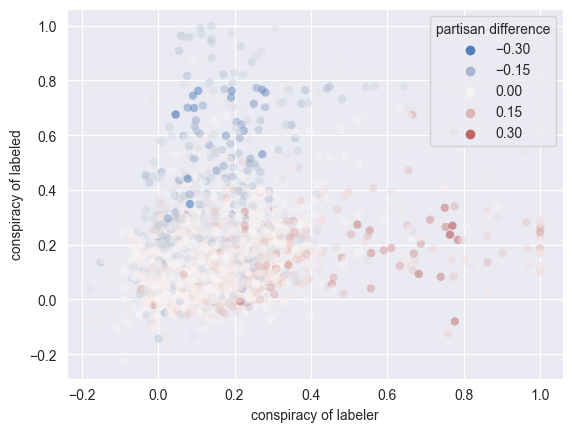

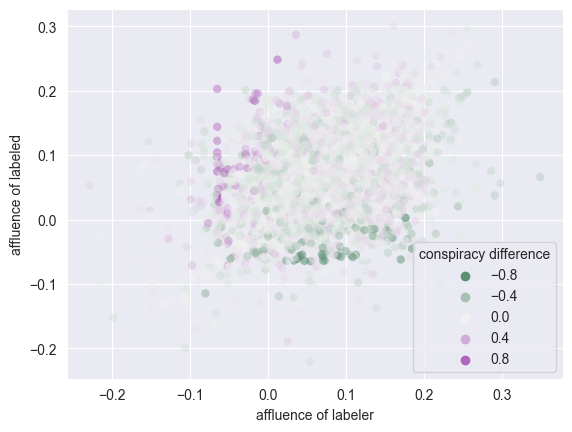

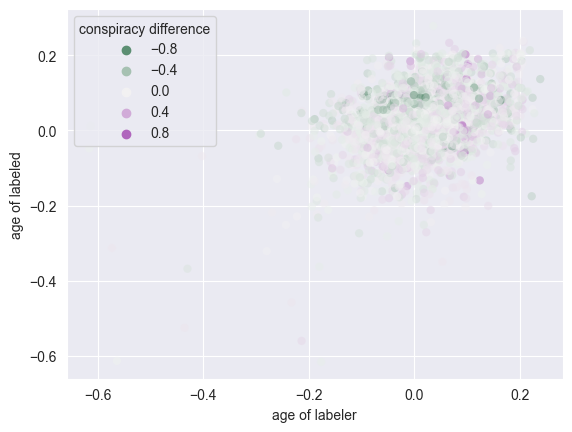

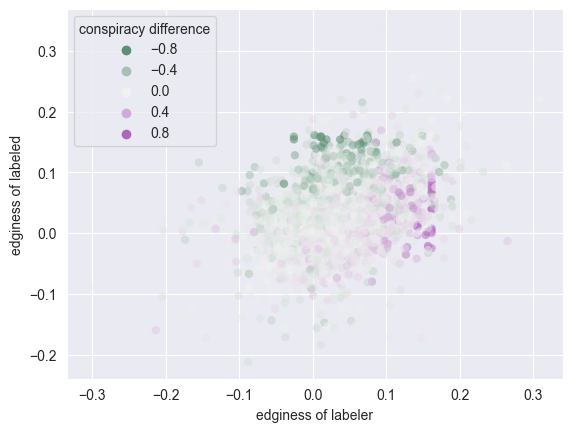

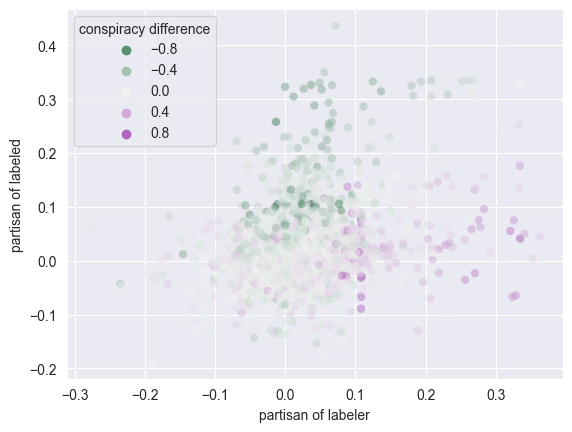

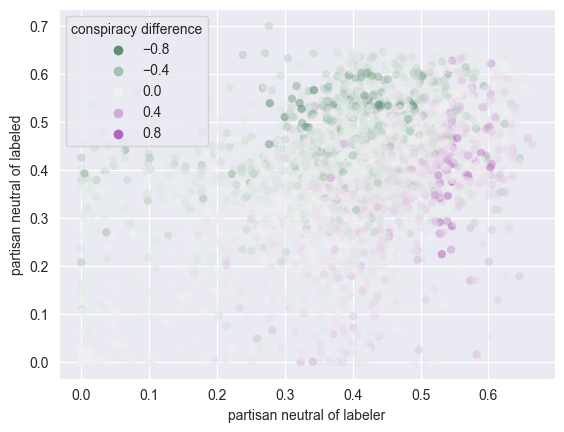

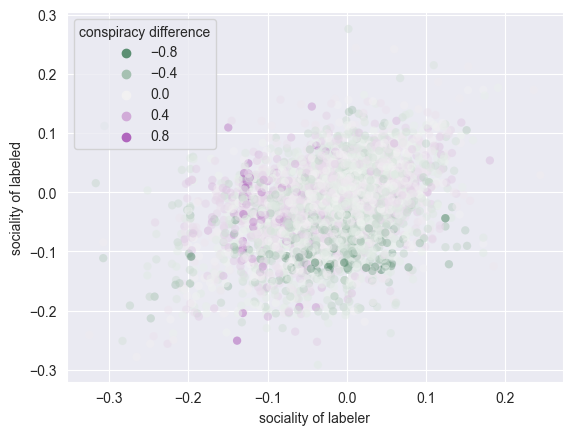

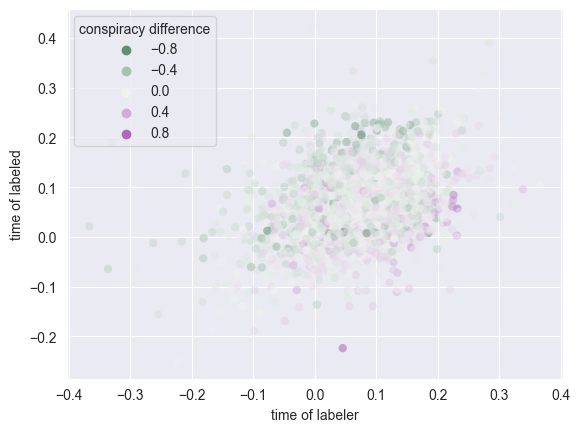

In [15]:

for col in user_cols:
    ax = sns.scatterplot(labeling_pairs, x=col, y=f'{col}_parent', alpha = .5,
                         hue=labeling_pairs.conspiracy-labeling_pairs.conspiracy_parent if col != 'conspiracy' else labeling_pairs.partisan-labeling_pairs.partisan_parent ,
                         # size=None if col != 'conspiracy' else labeling_pairs.affluence-labeling_pairs.affluence_parent,
                         palette=sns.diverging_palette(145, 300, s=60, as_cmap=True)if col != 'conspiracy' else 'vlag',
                         linewidth=0)
    ax.set_xlabel(f'{col} of labeler')
    ax.set_ylabel(f'{col} of labeled')
    ax.legend(title='conspiracy difference' if col != 'conspiracy' else 'partisan difference')
    savefig(f'../reports/figures/{col}_labeler_labeled_scatter.png', dpi=300, transparent=False)
    savefig(f'../reports/figures/{col}_labeler_labeled_scatter.pdf', transparent=False, bbox_inches='tight', )
    plt.show()

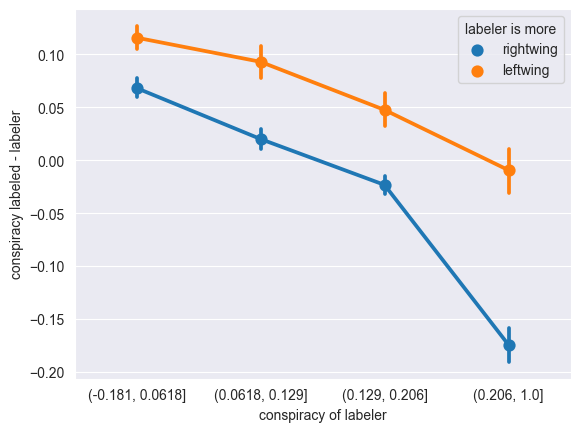

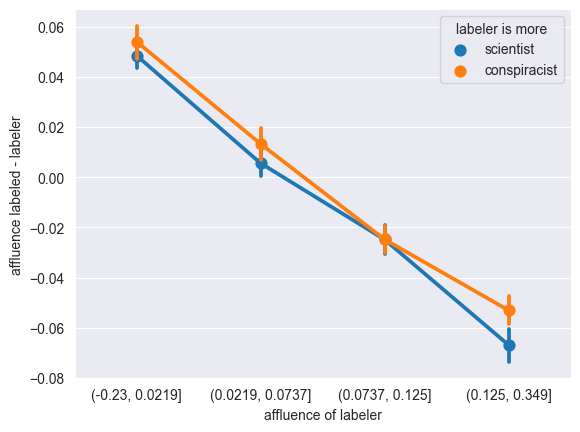

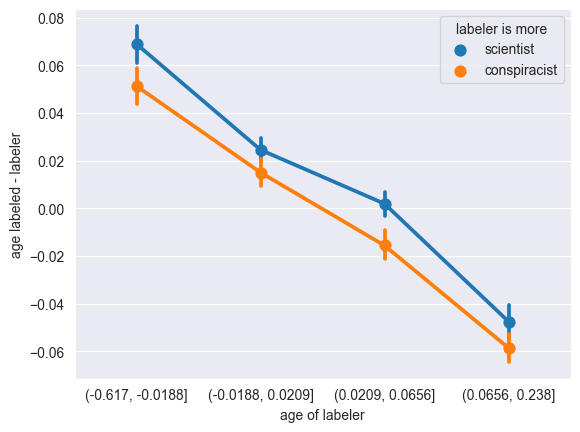

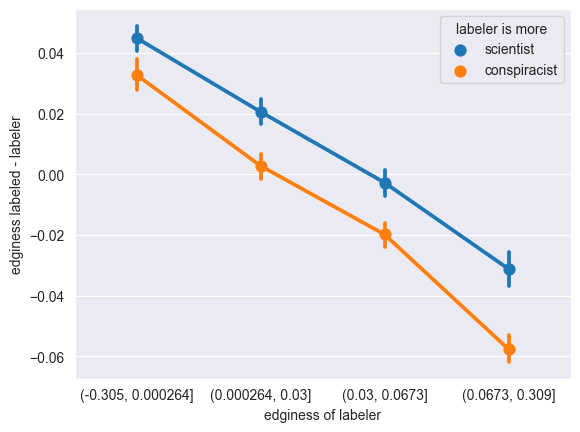

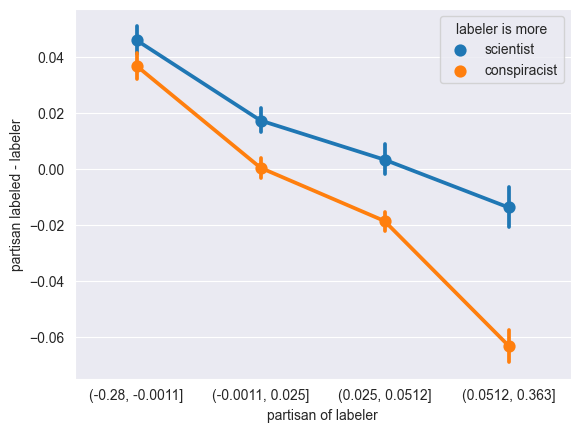

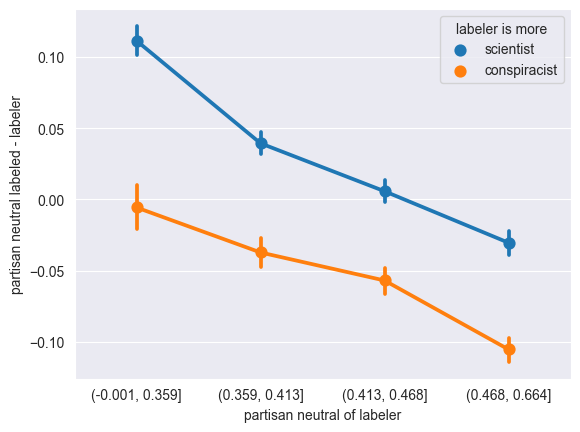

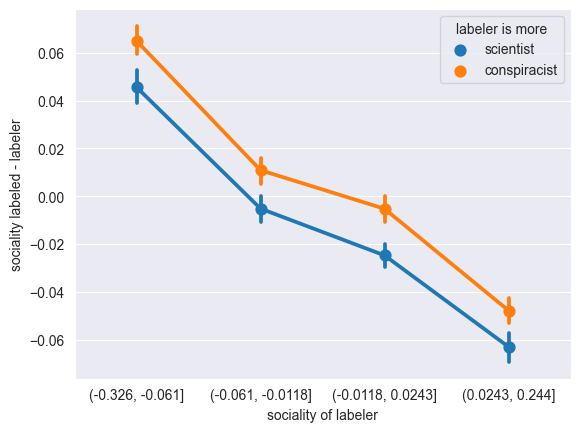

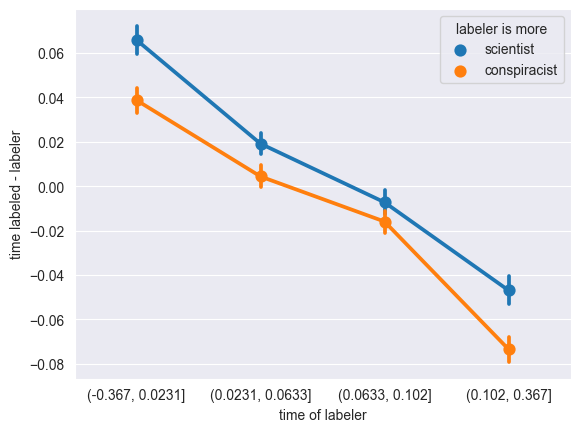

In [16]:

for col in user_cols:
    ax = sns.pointplot(x=pd.qcut(labeling_pairs[col], 4, ), y=labeling_pairs[f'{col}_parent']-labeling_pairs[f'{col}'],
                         hue=((labeling_pairs.conspiracy-labeling_pairs.conspiracy_parent)>0).map({True:'conspiracist', False:'scientist'})
                         if col != 'conspiracy' else ((labeling_pairs.partisan-labeling_pairs.partisan_parent)>0).map({True:'rightwing',False:'leftwing'}) ,
                         # size=None if col != 'conspiracy' else labeling_pairs.affluence-labeling_pairs.affluence_parent,
                         # palette=sns.diverging_palette(145, 300, s=60, as_cmap=True)if col != 'conspiracy' else 'vlag',
                         # linewidth=0
                       )
    ax.set_xlabel(f'{col} of labeler')
    ax.set_ylabel(f'{col} labeled - labeler')
    ax.legend(title='labeler is more' if col != 'conspiracy' else 'labeler is more')
    # savefig(f'../reports/figures/{col}_labeler_labeled_scatter.png', dpi=300, transparent=False)
    # savefig(f'../reports/figures/{col}_labeler_labeled_scatter.pdf', transparent=False, bbox_inches='tight', )
    plt.show()

In [ ]:

with pd.read_json('../data/interim/labeling_contributions_preprocessed_no_bot.jsonl', orient='records', lines=True, chunksize=500) as reader:
    df = pd.concat(chunk[chunk.contribution_type=='comment'][[ 'author', 'created_utc',
           'subreddit','text', 'fullname', 'parent_fullname',
           'link_fullname',]] for chunk in reader)

with open('../data/interim/perspective/labeling_contributions_preprocessed_no_bot_perspective.jsonl', encoding='utf8') as f:
    perspectives = dict()
    for obj in map(json.loads, f):
        k, v = list(obj.items())[0]
        perspectives[k] = parse_summary_scores(v)
perspective_df = pd.DataFrame(perspectives).T


with open('../data/interim/liwc/labeling_contributions_preprocessed_no_bot_liwc.jsonl', encoding='utf8') as f:
    liwcs = dict()
    for obj in map(json.loads, f):
        liwcs.update(obj)
liwc_df = pd.DataFrame(liwcs).T
liwc_df = liwc_df.divide(liwc_df.Tokens, axis=0)
del liwc_df['Tokens']

In [ ]:
with open('../data/interim/social_dimensions/labeling_contributions_preprocessed_no_bot_social_dimensions.jsonl', encoding='utf8') as f:
    social_dimensions = dict()
    for obj in map(json.loads, f):
        social_dimensions.update(obj)
social_dimensions_df = pd.DataFrame(social_dimensions).T


df = pd.merge(df, perspective_df, how='left', left_on='fullname', right_index=True)
df = pd.merge(df, social_dimensions_df, how='left', left_on='fullname', right_index=True)
df = pd.merge(df, liwc_df, how='left', left_on='fullname', right_index=True)

del perspective_df, social_dimensions_df, liwc_df,perspectives, liwcs, social_dimensions

In [ ]:
list(df.columns)

liwc_cols = ['Adverb',
 'Affect',
 'Article',
 'Auxverb',
 'Cause',
 'CogProc',
 'Conj',
 'Discrep',
 'FocusPresent',
 'Function',
 'Insight',
 'Ipron',
 'Posemo',
 'Ppron',
 'Pronoun',
 'Quant',
 'Social',
 'Tentat',
 'Verb',
 'You',
 'friend',
 'Tokens',
 'Achieve',
 'Adj',
 'Compare',
 'Drives',
 'I',
 'Motion',
 'Prep',
 'Relativ',
 'Reward',
 'Space',
 'they',
 'FocusFuture',
 'FocusPast',
 'Interrog',
 'SheHe',
 'differ',
 'male',
 'Anx',
 'Assent',
 'Bio',
 'Certain',
 'Health',
 'Informal',
 'Money',
 'Negate',
 'Negemo',
 'Netspeak',
 'Percept',
 'Power',
 'Relig',
 'Risk',
 'Sad',
 'Time',
 'feel',
 'Anger',
 'Body',
 'Death',
 'Nonflu',
 'See',
 'Swear',
 'female',
 'Affiliation',
 'Leisure',
 'Sexual',
 'family',
 'Ingest',
 'Work',
 'hear',
 'We',
 'home',
 'Filler']
social_cols=['conflict',
 'fun',
 'identity',
 'knowledge',
 'power',
 'respect',
 'romance',
 'similarity',
 'social_support',
 'trust',]
toxic_cols=['ATTACK_ON_AUTHOR',
 'ATTACK_ON_COMMENTER',
 'FLIRTATION',
 'IDENTITY_ATTACK',
 'INCOHERENT',
 'INFLAMMATORY',
 'INSULT',
 'LIKELY_TO_REJECT',
 'OBSCENE',
 'PROFANITY',
 'SEVERE_TOXICITY',
 'SEXUALLY_EXPLICIT',
 'SPAM',
 'THREAT',
 'TOXICITY',
 'UNSUBSTANTIAL',]

In [ ]:
df[liwc_cols] = df[liwc_cols].divide(df.Tokens, axis=0)

In [ ]:
df.head()

In [27]:
user_df = labeler_df
user_df.head()

,conspiracy,affluence,age,age B,age neutral,edginess,gender,gender B,gender neutral,partisan,partisan B,partisan B neutral,partisan neutral,sociality,time
GallowFroot,0.162281,0.080235,-0.046192,-0.059004,0.493092,0.063367,-0.024410,0.026420,0.431664,0.076811,0.063858,0.416249,0.420440,0.033946,0.124584
lie-twerker,0.334199,-0.078243,-0.052892,-0.016210,0.423090,-0.004301,0.187111,0.211298,0.403782,0.053580,0.105483,0.349728,0.306543,0.138508,0.121835
arduous_raven,0.062335,0.188243,-0.023091,-0.011270,0.521908,0.036400,-0.033094,0.018579,0.441465,0.014570,-0.026937,0.401205,0.440431,0.043603,0.083971
thrawnpop,0.086708,-0.004740,0.022127,0.030912,0.065832,0.017135,0.012276,-0.003803,0.051026,-0.002335,0.010144,0.060803,0.055966,-0.017333,-0.004110
SPACEMANTIMEZ,0.297257,0.162604,0.061887,0.021390,0.519869,0.001225,0.097639,0.090844,0.483203,-0.008656,-0.042643,0.513038,0.491142,-0.039786,0.033664


In [28]:
# attempt hierarchical modeling

to_regress = pd.merge(df, user_df, how='left', left_on='author', right_index=True)

In [29]:

target_var = 'conspiracy'
md = smf.mixedlm(f"{target_var} ~ {'+'.join(toxic_cols)}", data=to_regress.dropna().sample(1000), groups="author", re_formula='+'.join(['affluence', 'age', 'partisan', 'sociality', 'time']))
mdf = md.fit()
print(mdf.summary())

C:\Users\hide\PycharmProjects\trutherstoo\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hide\PycharmProjects\trutherstoo\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\hide\PycharmProjects\trutherstoo\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     conspiracy
No. Observations:     1000        Method:                 REML      
No. Groups:           995         Scale:                  0.0036    
Min. group size:      1           Log-Likelihood:         757.4908  
Max. group size:      2           Converged:              Yes       
Mean group size:      1.0                                           
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.112    0.016  7.195 0.000  0.081  0.142
ATTACK_ON_AUTHOR          -0.026    0.018 -1.464 0.143 -0.060  0.009
ATTACK_ON_COMMENTER        0.016    0.014  1.105 0.269 -0.012  0.043
FLIRTATION                -0.031    0.038 -0.819 0.413 -0.105  0.043
IDENTITY_ATTACK           -0.007    0.034 -0.200 0

In [30]:
dep_var = 'TOXICITY'
indep_vars = ['conspiracy', 'affluence', 'age', 'partisan', #'sociality', 'time'
              ]
group='author'
md = smf.ols(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress[[dep_var, group]+indep_vars].dropna().groupby([group]+indep_vars).mean().reset_index())
# md = smf.mixedlm(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress[[dep_var, group]+indep_vars].dropna(), groups=group)
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:               TOXICITY   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     551.6
Date:                Mon, 27 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:49:50   Log-Likelihood:             1.4027e+05
No. Observations:              544886   AIC:                        -2.805e+05
Df Residuals:                  544881   BIC:                        -2.805e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2657      0.000    589.863      0.0

In [31]:
dep_var = 'conspiracy'
indep_vars = [i for i in liwc_cols if i in to_regress.columns]+toxic_cols+social_cols
group='author'
md = smf.ols(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress[[dep_var, group]+indep_vars].dropna().groupby([group]+indep_vars).mean().reset_index())
# md = smf.mixedlm(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress[[dep_var, group]+indep_vars].dropna(), groups=group)
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:             conspiracy   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     136.3
Date:                Mon, 27 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:50:37   Log-Likelihood:             4.9356e+05
No. Observations:             1083699   AIC:                        -9.869e+05
Df Residuals:                 1083600   BIC:                        -9.857e+05
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0835    

In [32]:
dep_var = 'partisan'
indep_vars = [i for i in liwc_cols if i in to_regress.columns]+toxic_cols+social_cols
group='author'
md = smf.ols(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress[[dep_var, group]+indep_vars].dropna().groupby([group]+indep_vars).mean().reset_index())
# md = smf.mixedlm(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress[[dep_var, group]+indep_vars].dropna(), groups=group)
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:               partisan   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     105.8
Date:                Mon, 27 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:51:36   Log-Likelihood:             1.6338e+06
No. Observations:             1083699   AIC:                        -3.267e+06
Df Residuals:                 1083600   BIC:                        -3.266e+06
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0086    

In [33]:

results_summary = mdf.summary()

# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_as_html = results_summary.tables[1].as_html()
pd.read_html(results_as_html, header=0, index_col=0)[0]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.008600,0.001,12.958,0.000,0.007,0.010
Adverb,0.007600,0.002,4.902,0.000,0.005,0.011
Affect,0.005000,0.004,1.172,0.241,-0.003,0.013
Article,0.023800,0.002,15.247,0.000,0.021,0.027
Auxverb,0.020600,0.002,11.244,0.000,0.017,0.024
...,...,...,...,...,...,...
respect,-0.001500,0.001,-2.404,0.016,-0.003,-0.000
romance,0.002800,0.001,2.437,0.015,0.001,0.005
similarity,0.000019,0.000,0.066,0.947,-0.001,0.001
social_support,-0.005900,0.001,-4.818,0.000,-0.008,-0.004


In [22]:
mean_df = df[[c for c in df.columns if c not in {'created_utc', 'subreddit', 'text',
                                      'fullname',
                                      'parent_fullname', 'link_fullname'}]].groupby('author').mean()

In [23]:
mean_df.head()

,ATTACK_ON_AUTHOR,ATTACK_ON_COMMENTER,FLIRTATION,IDENTITY_ATTACK,INCOHERENT,INFLAMMATORY,INSULT,LIKELY_TO_REJECT,OBSCENE,PROFANITY,...,Affiliation,Leisure,Sexual,family,Ingest,Work,hear,We,home,Filler
author,,,,,,,,,,,,,,,,,,,,,
----------------fuck,0.081933,0.696846,0.306964,0.367026,0.686348,0.780436,0.498691,0.704208,0.051485,0.492594,...,0.029851,0.000000,0.000000,0.0,0.0,0.014925,0.029851,0.029851,0.0,0.0
---------_----_---_,0.329614,0.261148,0.320017,0.043226,0.214240,0.364906,0.519861,0.561594,0.338142,0.243875,...,0.012821,0.000000,0.000000,0.0,0.0,0.018668,0.000000,0.012821,0.0,0.0
--------V--------,0.620920,0.727617,0.203574,0.005550,0.890323,0.639493,0.072701,0.818072,0.127282,0.019964,...,0.028571,0.000000,0.000000,0.0,0.0,0.000000,0.028571,0.028571,0.0,0.0
-------_-----,0.008301,0.160138,0.198003,0.059766,0.085357,0.436962,0.392980,0.996588,0.993693,0.644600,...,0.009346,0.018692,0.009346,0.0,0.0,0.009346,0.000000,0.000000,0.0,0.0
-----1,0.358992,0.355179,0.178002,0.004532,0.501877,0.650783,0.024124,0.337144,0.010805,0.013200,...,0.023256,0.023256,0.000000,0.0,0.0,0.023256,0.023256,0.046512,0.0,0.0


In [35]:
import seaborn as sns

In [38]:
dh=mean_df.head()

In [50]:
toplot = pd.merge(mean_df.reset_index().melt(id_vars=['author']).set_index('author'), pd.qcut(user_df['conspiracy'], 2, labels=False), how='left', left_index=True, right_index=True)

In [ ]:
user_characteristics = ['affluence', 'age', 'partisan', 'sociality', 'time', 'edginess', 'gender', 'conspiracy']
sns.stripplot(data = toplot, hue='conspiracy', x='value', y='variable', )